<a href="https://colab.research.google.com/github/Valiev-Koyiljon/DigitRecognizer/blob/main/DigitRecognizerWithPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Logistic Regression

In [2]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [4]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

## Dataset & Data loaders

In [5]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

100%|██████████| 9912422/9912422 [00:00<00:00, 285755503.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18020781.59it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124163220.76it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11680275.15it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label: 4


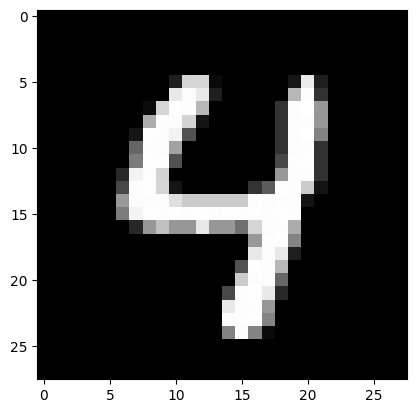

In [6]:
image, label = train_ds[4]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Label: 4


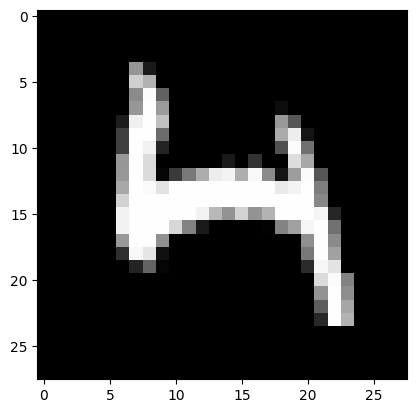

In [7]:
image, label = train_ds[440]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

## Training

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
evaluate(model, val_loader)

{'val_loss': 2.3339648246765137, 'val_acc': 0.05605468899011612}

In [25]:
history = fit(5, 0.009, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9173, val_acc: 0.8324
Epoch [1], val_loss: 0.6800, val_acc: 0.8574
Epoch [2], val_loss: 0.5834, val_acc: 0.8663
Epoch [3], val_loss: 0.5294, val_acc: 0.8736
Epoch [4], val_loss: 0.4942, val_acc: 0.8784


In [26]:
history1 = fit(5, 0.009, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4689, val_acc: 0.8818
Epoch [1], val_loss: 0.4501, val_acc: 0.8844
Epoch [2], val_loss: 0.4352, val_acc: 0.8864
Epoch [3], val_loss: 0.4230, val_acc: 0.8880
Epoch [4], val_loss: 0.4128, val_acc: 0.8897


In [27]:
history2 = fit(5, 0.009, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4042, val_acc: 0.8919
Epoch [1], val_loss: 0.3968, val_acc: 0.8937
Epoch [2], val_loss: 0.3904, val_acc: 0.8947
Epoch [3], val_loss: 0.3846, val_acc: 0.8959
Epoch [4], val_loss: 0.3795, val_acc: 0.8967


In [28]:
historyZ = history+history1+history2

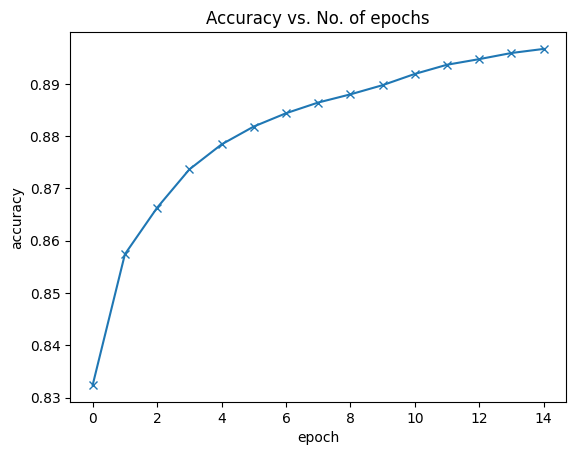

In [29]:
accuracies = [r['val_acc'] for r in historyZ]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [30]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.36656665802001953, 'val_acc': 0.90185546875}

## Prediction

In [31]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


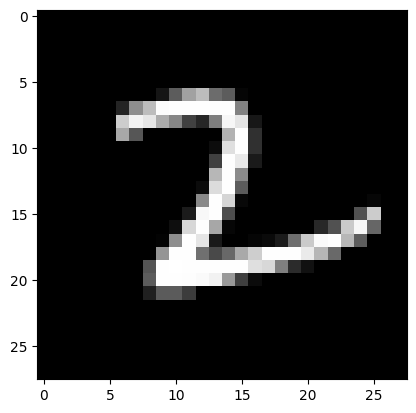

In [32]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

label:3,  predicted: 3


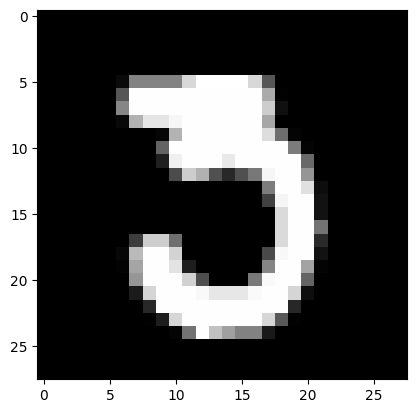

In [36]:
img, label = test_ds[5623]
plt.imshow(img[0], cmap="gray")
print(f"label:{label},  predicted: {predict_image(img, model)}")

## Save and upload

In [37]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

Overall, We trained digit recognition model using logistic regression on Pytorch with nearly 90 % accuracy.